In [1]:
import numpy as np
import pandas as pd
columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "level"]
attack_type = {
    0: 'normal',
    1: 'DOS',
    2: 'Probe',
    3: 'R2L',
    4: 'U2R'
}

new_label = {
    'normal': 0,
    'apache2': 1,
    'back': 1,
    'mailbomb': 1,
    'processtable': 1,
    'snmpgetattack': 1,
    'teardrop': 1,
    'smurf': 1,
    'land': 1,
    'neptune': 1,
    'pod': 1,
    'udpstorm': 1,
    'nmap': 2,
    'ipsweep': 2,
    'portsweep': 2,
    'satan': 2,
    'mscan': 2,
    'saint': 2,
    'ftp_write': 3,
    'guess_passwd': 3,
    'snmpguess': 3,
    'imap': 3,
    'spy': 3,
    'warezclient': 3,
    'warezmaster': 3,
    'multihop': 3,
    'phf': 3,
    'imap': 3,
    'named': 3,
    'sendmail': 3,
    'xlock': 3,
    'xsnoop': 3,
    'worm': 3,
    'ps': 4,
    'buffer_overflow': 4,
    'perl': 4,
    'rootkit': 4,
    'loadmodule': 4,
    'xterm': 4,
    'sqlattack': 4,
    'httptunnel': 4
}

# Preprocessing dataset

Drop na and duplicates

In [2]:
train = pd.read_csv("NSL-KDD/KDDTrain+.txt", header=None)
train.columns = columns
train = train.dropna()
train = train.drop_duplicates()
test = pd.read_csv("NSL-KDD/KDDTest+.txt", header=None)
test.columns = columns
test = test.dropna()
test = test.drop_duplicates()

In [3]:
last_index_train = train.index.to_list()[-1]
df = pd.concat([train, test])

In [4]:
df.shape

(148517, 43)

OneHotEncoder at `protocol_type`, `service` and `flag` 

In [5]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [6]:
from preprocessing import encode_text_dummy
encode_text_dummy(df=df, name="protocol_type")
encode_text_dummy(df=df, name="service")
encode_text_dummy(df=df, name="flag")

In [7]:
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
22540,0,317,938,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,1,0
22542,0,42,42,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Split to train and test set

In [8]:
train = df.iloc[:last_index_train+1]
test = df.iloc[last_index_train+1:]
X_train = train.drop(columns=['label', 'level'])
y_train = train.label.map(new_label).map(attack_type)
X_test = test.drop(columns=['label', 'level'])
y_test = test.label.map(new_label).map(attack_type)

Normalize trainset/testset

In [9]:
from sklearn.preprocessing import MinMaxScaler
features = X_train.columns
scalser = MinMaxScaler()
scalser.fit(X_train)
X_train = scalser.transform(X_train)
X_test = scalser.transform(X_test)

SMOTE for balance dataset

In [10]:
y_train.value_counts()

label
normal    67343
DOS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

In [11]:
from imblearn.over_sampling import SMOTE

desired_samples = {
    "U2R": 5000,
    "R2L": 5000
}

bal = SMOTE(sampling_strategy=desired_samples)

X_train, y_train = bal.fit_resample(X_train, y_train)

In [12]:
y_train.value_counts()

label
normal    67343
DOS       45927
Probe     11656
R2L        5000
U2R        5000
Name: count, dtype: int64

# DEEP NEURAL MODEL

In [13]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])
encode_text_dummy(y_train, 'label')
encode_text_dummy(y_test, 'label')

In [18]:
X_train.to_csv("NSL-KDD/X_train.csv")
y_train.to_csv("NSL-KDD/y_train.csv")
X_test.to_csv("NSL-KDD/X_test.csv")
y_test.to_csv("NSL-KDD/y_test.csv")

In [16]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
y_train.head()

,label_DOS,label_Probe,label_R2L,label_U2R,label_normal
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [19]:
import tensorflow as tf
from art.estimators.tensorflow import TensorFlowV2Estimator

layers = [
    tf.keras.layers.Dense(X_train.shape[0], activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
]
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn = tf.keras.models.Sequential(layers=layers)
dnn.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)
dnn.fit(
    x=X_train,
    y=y_train.values,
    epochs=5,
    batch_size=1024
)

2023-07-14 12:14:12.001650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 12:14:12.064656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 12:14:12.065940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 12:14:13.286680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/zauzooz/DNN_SHAP_AE/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zauzooz/DNN_SHAP_AE

Epoch 1/5
132/132 [==============================] - 170s 1s/step - loss: 0.1466 - accuracy: 0.9538 - precision: 0.9696 - recall: 0.9372
Epoch 2/5
132/132 [==============================] - 175s 1s/step - loss: 0.0440 - accuracy: 0.9845 - precision: 0.9854 - recall: 0.9837
Epoch 3/5
132/132 [==============================] - 172s 1s/step - loss: 0.0431 - accuracy: 0.9856 - precision: 0.9863 - recall: 0.9846
Epoch 4/5
132/132 [==============================] - 177s 1s/step - loss: 0.0306 - accuracy: 0.9893 - precision: 0.9899 - recall: 0.9888
Epoch 5/5
132/132 [==============================] - 169s 1s/step - loss: 0.0253 - accuracy: 0.9914 - precision: 0.9919 - recall: 0.9910


In [20]:
dnn.save("NSL-KDD/dnn.h5")

/home/zauzooz/DNN_SHAP_AE/.conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ART

load model, train and test set

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

dnn = tf.keras.models.load_model("NSL-KDD/dnn.h5")
X_train = pd.read_csv("NSL-KDD/X_train.csv").drop(columns=['Unnamed: 0'])
y_train = pd.read_csv("NSL-KDD/y_train.csv").drop(columns=['Unnamed: 0'])
X_test = pd.read_csv("NSL-KDD/X_test.csv").drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("NSL-KDD/y_test.csv").drop(columns=['Unnamed: 0'])

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model = TensorFlowV2Classifier(
    model=dnn,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=5,
    input_shape=X_train.shape
)

In [30]:
from evaluation_metric import evaluate_metric
evaluate_metric(y_pred=dnn_model.predict(x=X_test), y_true=y_test.values)

{'confusion_matrix': array([[5751,   42,  481,    2, 1360],
        [ 179, 1792,   94,    3,  353],
        [   0,    8,  414,  109, 2045],
        [   0,   16,    8,   41,  135],
        [  58,  198,    8,   19, 9428]]),
 'accuracy_score': 0.7729772888573456,
 'precision_score': 0.7729772888573456,
 'recall_score': 0.7729772888573456,
 'f1_score': 0.7729772888573457}

In [4]:
samples = X_test.sample(n=500)
y_samples = y_test.iloc[samples.index]

In [6]:
from evaluation_metric import evaluate_metric
evaluate_metric(
    y_pred=dnn_model.predict(x=samples),
    y_true=y_samples
)

{'confusion_matrix': array([[118,   1,   7,   0,  32],
        [  3,  41,   0,   0,   6],
        [  0,   0,  12,   2,  53],
        [  0,   0,   0,   4,   8],
        [  1,   3,   0,   1, 208]]),
 'accuracy_score': 0.766,
 'precision_score': 0.766,
 'recall_score': 0.766,
 'f1_score': 0.766}

calculate shap values

In [7]:
# background = X_train.sample(500)
# background.to_csv("NSL-KDD/samples/background.csv")
# samples.to_csv("NSL-KDD/samples/samples.csv")
# y_samples.to_csv("NSL-KDD/samples/y_samples.csv")

In [11]:
import shap
from shap_importance import shap_importance

background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])

explainer = shap.DeepExplainer(model=dnn, data=background.values)
shap_vals = explainer.shap_values(samples.values)

accuracy plot when increase number of adversarial features

In [15]:
import pickle
import pandas as pd
import numpy as np
from adversarial_n_best_worst_features import adversarial_n_best_worst_features
from shap_importance import shap_importance
from art.attacks.evasion.fast_gradient import FastGradientMethod
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from art.attacks.evasion.saliency_map import SaliencyMapMethod
from art.attacks.evasion.carlini import CarliniL0Method, CarliniLInfMethod ,CarliniL2Method
from art.attacks.evasion.deepfool import DeepFool

# background = pd.read_csv("NSL-KDD/samples/background.csv").drop(columns=["Unnamed: 0"])
samples = pd.read_csv("NSL-KDD/samples/samples.csv").drop(columns=["Unnamed: 0"])
y_samples = pd.read_csv("NSL-KDD/samples/y_samples.csv").drop(columns=["Unnamed: 0"])
shap_vals = pickle.load(open("NSL-KDD/samples/shap_vals_of_samples.pkl","rb"))
shap_vals = [np.array(val) for val in shap_vals]

adversarial_algs = {
    "Fast Gradient Method": FastGradientMethod(estimator=dnn_model, eps=0.2),
    "Basic Interative Method": BasicIterativeMethod(estimator=dnn_model, eps=0.2, max_iter=100, batch_size=32),
    "Carlini L0Method": CarliniL0Method(classifier=dnn_model, max_iter=10),
    "Carlini LInf Method": CarliniLInfMethod(classifier=dnn_model, max_iter=10),
    "Carlini L2 Method": CarliniL2Method(classifier=dnn_model, max_iter=10),
    "Saliency Map Method": SaliencyMapMethod(classifier=dnn_model,theta=0.1,gamma=1, batch_size=1),
    "DeepFool": DeepFool(classifier=dnn_model, max_iter=100, epsilon=0.000001, nb_grads=10, batch_size=1),
}

# 
full_features = samples.columns
selected_features = [f for f in shap_importance(full_features, shap_val_of_sample=shap_vals).column_name.values.tolist() \
                     if 'protocol_type' not in f and 'service' not in f and 'flag' not in f]

In [16]:
acc_list = []

for alg_name in adversarial_algs:
    alg = adversarial_algs[alg_name]
    org_samples = samples.copy()
    adv_samples = alg.generate(x=org_samples.values)
    adv_samples = pd.DataFrame(adv_samples, columns=full_features)
    
    acc_list.append(adversarial_n_best_worst_features(
        model=dnn_model,
        selected_features=selected_features,
        samples=org_samples,
        adv_samples=adv_samples,
        y_true=y_samples
    ))

Fast Gradient Method

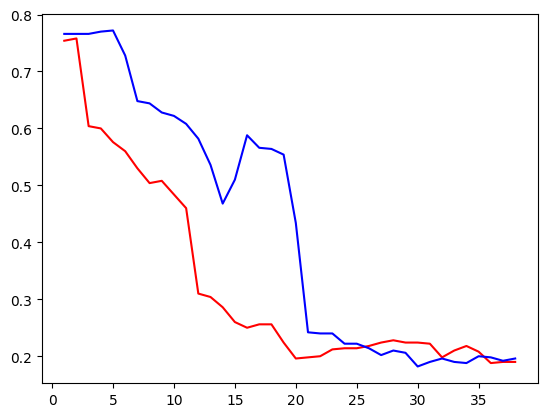

In [17]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[0][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[0][1] , 'blue')

plt.show()

Basic Interactive Method

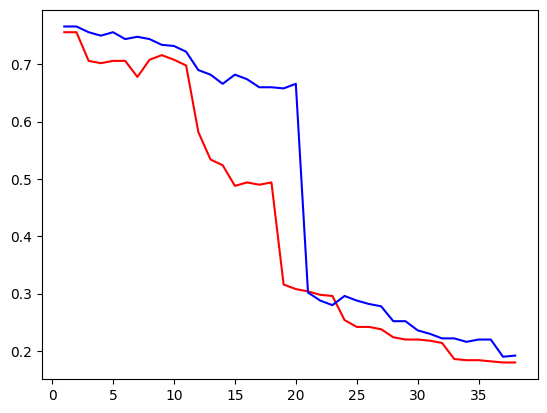

In [18]:
import matplotlib.pyplot as plt
plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[1][0], 'red')

plt.plot(
    [a+1 for a in range(len(selected_features))],
    acc_list[1][1] , 'blue')

plt.show()